In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
df = pd.read_csv('dataset/DTW_to_MIA.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289413 entries, 0 to 289412
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         289413 non-null  int64  
 1   legId                              289413 non-null  object 
 2   searchDate                         289413 non-null  object 
 3   flightDate                         289413 non-null  object 
 4   startingAirport                    289413 non-null  object 
 5   destinationAirport                 289413 non-null  object 
 6   fareBasisCode                      289413 non-null  object 
 7   travelDuration                     289413 non-null  object 
 8   elapsedDays                        289413 non-null  int64  
 9   isBasicEconomy                     289413 non-null  bool   
 10  isRefundable                       289413 non-null  bool   
 11  isNonStop                          2894

In [4]:
# only focus on nonstop flights and pick useful columns
df = df[df['isNonStop'] == True]
df = df.iloc[:,[2,3,7,8,9,10,12,14,15,17,19,22,24,27]]

In [5]:
# totalTravelDistance and isRefundable variables have no variance, so remove this column
print(df['totalTravelDistance'].value_counts())
print(df['isRefundable'].value_counts())
df.drop(['totalTravelDistance','isRefundable'], axis=1, inplace=True)
# Arrival time is decided by departure time and travel duration so it is redundant, remove it
df.drop(['segmentsArrivalTimeRaw'], axis=1, inplace=True)

1153.0    23727
Name: totalTravelDistance, dtype: int64
False    40131
Name: isRefundable, dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40131 entries, 2 to 289412
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   searchDate                    40131 non-null  object 
 1   flightDate                    40131 non-null  object 
 2   travelDuration                40131 non-null  object 
 3   elapsedDays                   40131 non-null  int64  
 4   isBasicEconomy                40131 non-null  bool   
 5   baseFare                      40131 non-null  float64
 6   seatsRemaining                40131 non-null  int64  
 7   segmentsDepartureTimeRaw      40131 non-null  object 
 8   segmentsAirlineName           40131 non-null  object 
 9   segmentsEquipmentDescription  39756 non-null  object 
 10  segmentsCabinCode             40131 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 3.4+ MB


## Deal with Missing Data

In [7]:
df.isna().sum()

searchDate                        0
flightDate                        0
travelDuration                    0
elapsedDays                       0
isBasicEconomy                    0
baseFare                          0
seatsRemaining                    0
segmentsDepartureTimeRaw          0
segmentsAirlineName               0
segmentsEquipmentDescription    375
segmentsCabinCode                 0
dtype: int64

In [8]:
# remove the rows with missing values
df = df.dropna()

## Change the Format of Some Variables

In [9]:
#travelDuration to hours
dates = []
for date in df['travelDuration'].values:
    if date[4:-1] != '':
        dates.append(int(date[2]) + round(float(date[4:-1])/60,1))
    else:
        dates.append(int(date[2]))
df['travelDuration'] = dates

In [10]:
# change flightDate to Date type
df['flightDate'] = pd.to_datetime(df['flightDate'])

In [11]:
# change searchDate to the days before flight days
df['searchDaysBeforeDepartue'] = (df['flightDate']-pd.to_datetime(df['searchDate'])).dt.days.astype(int)
df.drop(['searchDate'], axis=1, inplace=True)

In [12]:
# convert flightDate to the weekday 
df['flightDay'] = df['flightDate'].dt.day_name()
df.drop(['flightDate'], axis=1, inplace=True)

In [13]:
# change segmentsDepartureTimeRaw to four time categories
time_category = []
for date in df['segmentsDepartureTimeRaw'].values:
    time = int(date[11:13])
    if time >= 0 and time < 6:
        time_category.append('Night')
    elif time >= 6 and time < 12:
        time_category.append('Morning')
    elif time >=12 and time < 18:
        time_category.append('Afternoon')
    else:
        time_category.append('Evening')
df['departureTime'] = time_category
df.drop(['segmentsDepartureTimeRaw'], axis=1, inplace=True)

In [14]:
# rename some variables
df = df.rename(columns={"segmentsAirlineName": "airlineName", "segmentsEquipmentDescription": "equipmentDescription", 
                  "segmentsCabinCode": "cabinCode"})

In [15]:
df.head()

,travelDuration,elapsedDays,isBasicEconomy,baseFare,seatsRemaining,airlineName,equipmentDescription,cabinCode,searchDaysBeforeDepartue,flightDay,departureTime
2,3.1,0,False,140.00,0,Spirit Airlines,AIRBUS INDUSTRIE A321 SHARKLETS,coach,1,Sunday,Morning
3,3.0,0,False,262.33,2,Delta,Boeing 737-900,coach,1,Sunday,Afternoon
4,3.0,0,False,262.33,7,Delta,Airbus A321,coach,1,Sunday,Morning
5,3.1,0,False,262.33,7,American Airlines,Embraer 175,coach,1,Sunday,Afternoon
6,3.1,0,False,262.33,7,American Airlines,Boeing 737-800,coach,1,Sunday,Morning


In [16]:
df.shape

(39756, 11)

## Drop Spirit Rows

In [17]:
df = df[~df.airlineName.str.match('Spirit')]

In [18]:
df.shape

(23861, 11)

In [19]:
# Drop elapsedDays column as it has no variance
df.drop(['elapsedDays'], axis=1, inplace=True)

## EDA

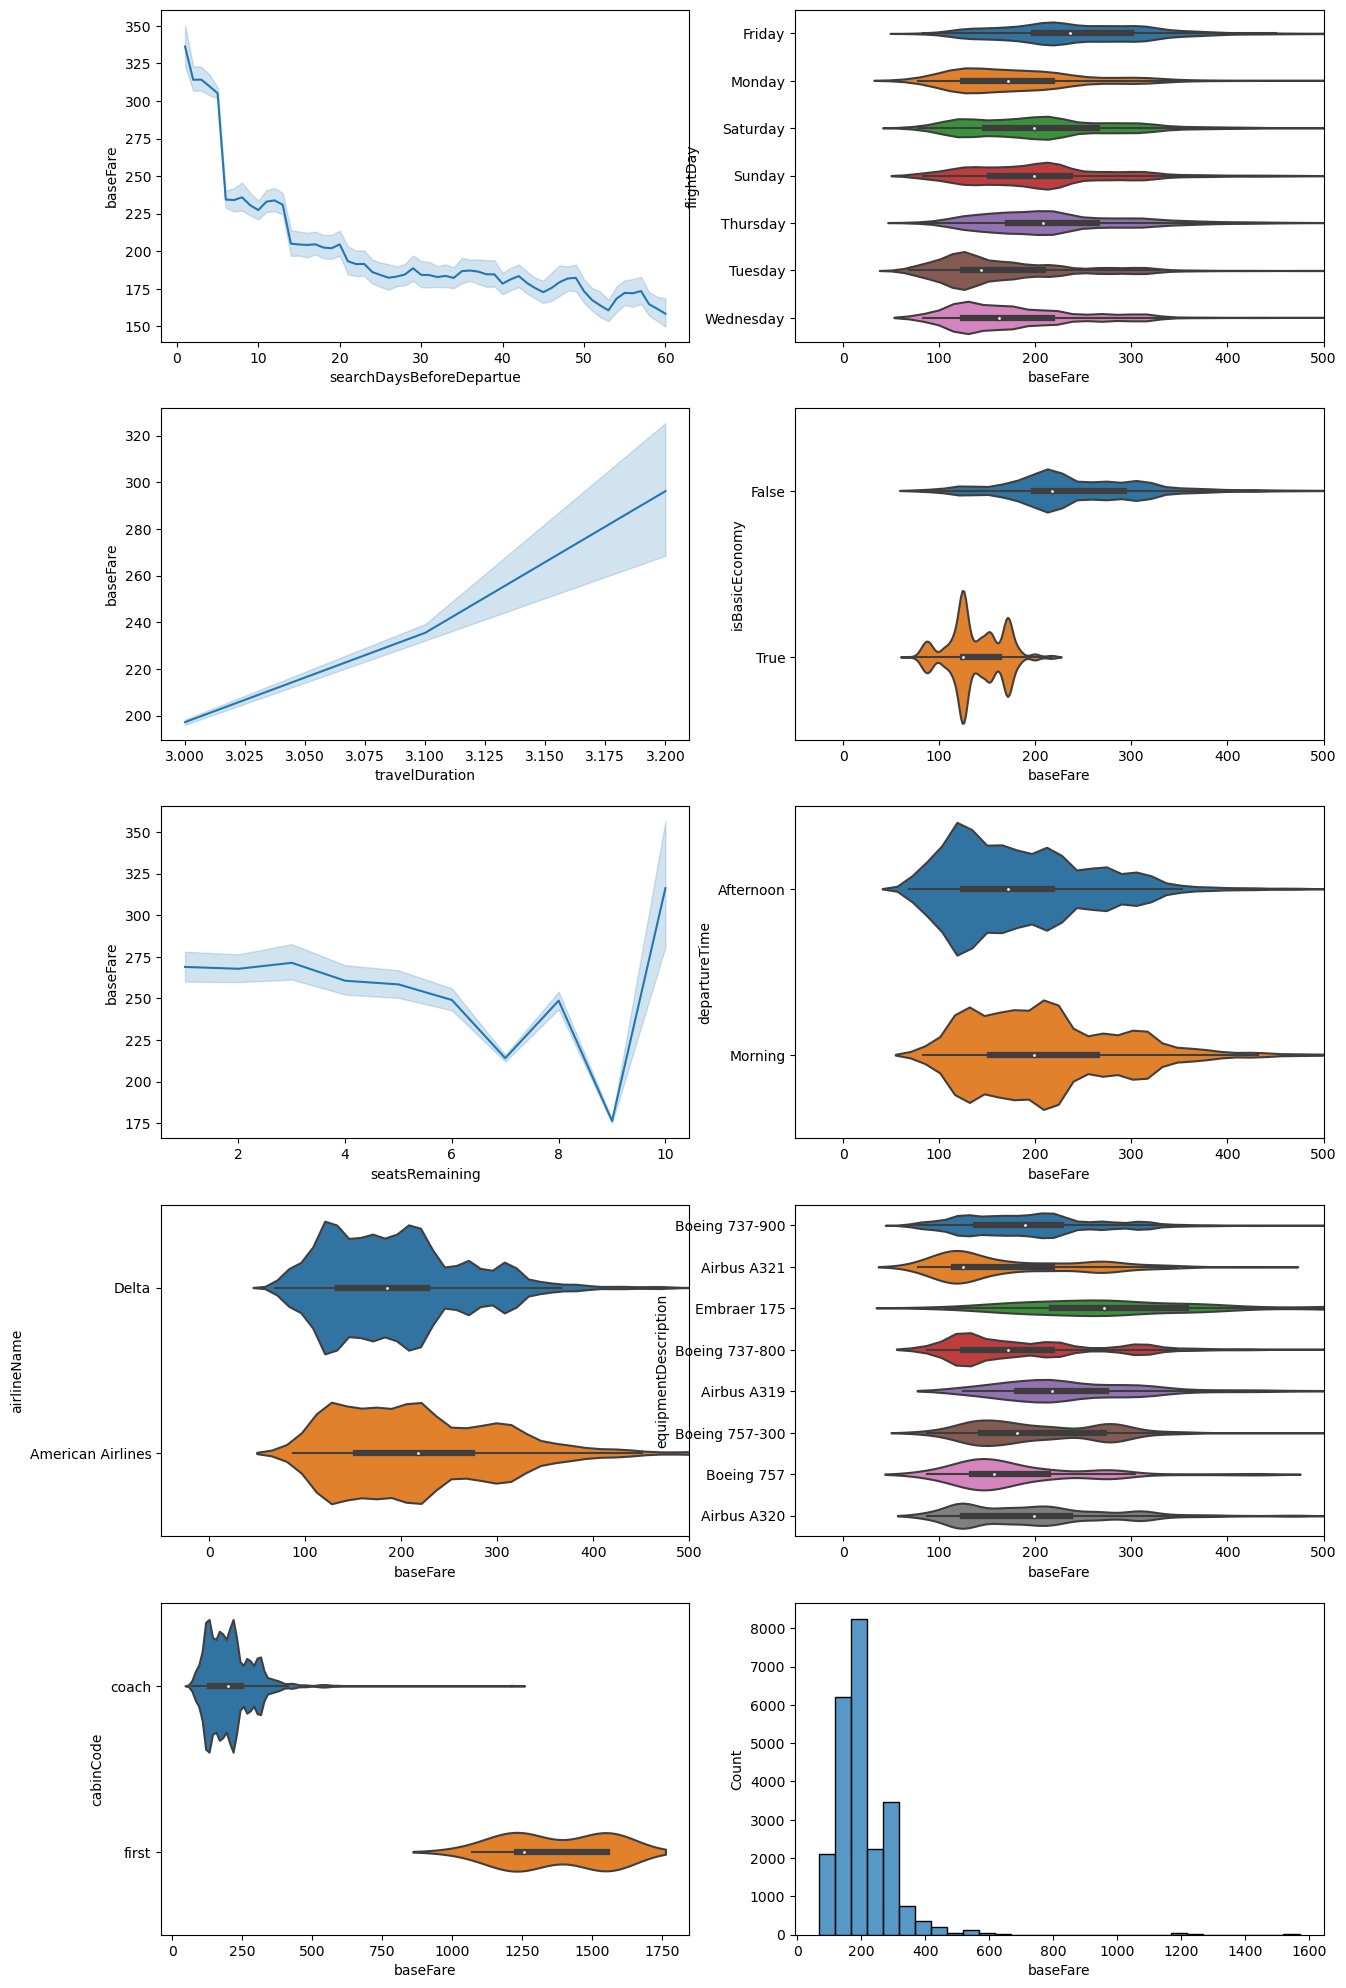

In [20]:
fig, axes = plt.subplots(5,2, figsize=(15,25))
sns.lineplot(ax=axes[0,0], x=df['searchDaysBeforeDepartue'], y=df['baseFare'])
sns.violinplot(ax=axes[0,1], y=df['flightDay'].astype('category'), x=df['baseFare'])
axes[0,1].set_xlim(-50, 500)
sns.lineplot(ax=axes[1,0], x=df['travelDuration'], y=df['baseFare'])
sns.violinplot(ax=axes[1,1], y=df['isBasicEconomy'].astype('category'), x=df['baseFare'])
axes[1,1].set_xlim(-50, 500)
sns.lineplot(ax=axes[2,0], x=df['seatsRemaining'].astype('category'), y=df['baseFare'])
sns.violinplot(ax=axes[2,1], y=df['departureTime'].astype('category'), x=df['baseFare'])
axes[2,1].set_xlim(-50, 500)
sns.violinplot(ax=axes[3,0], y=df['airlineName'], x=df['baseFare'])
axes[3,0].set_xlim(-50, 500)
sns.violinplot(ax=axes[3,1], y=df['equipmentDescription'], x=df['baseFare'])
axes[3,1].set_xlim(-50, 500)
sns.violinplot(ax=axes[4,0], y=df['cabinCode'], x=df['baseFare'])
sns.histplot(ax=axes[4,1], x=df['baseFare'], binwidth=50)
plt.show()

In [21]:
# For simplicity, combine some categories in the equipment description variable
df = df.replace(regex=r'^Boeing.*', value='Other')
df = df.replace(regex=r'^Airbus.*', value='Other')
df = df.replace(regex=r'^Embraer.*', value='Embraer')

In [22]:
# Combine some categories in flightDay variable
df = df.replace({'flightDay': {'Monday':False, 'Tuesday':True, 'Wednesday':True, 'Thursday':False, 
                         'Friday':False, 'Saturday':False, 'Sunday':False}})

## One-Hot Encoding

In [23]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
categorical_column = ['isBasicEconomy', 'cabinCode', 'airlineName', 'departureTime', 'flightDay', 
                      'equipmentDescription']
enc = OneHotEncoder(drop='if_binary')
df[categorical_column[:]] = csr_matrix.toarray(enc.fit_transform(df.loc[:,categorical_column[:]]))

In [24]:
df = df.rename(columns={'airlineName':'isDelta', 'cabinCode':'isFirstCabin', 'departureTime':'isDepartureMorning', 
                        'flightDay':'isFlightTueWed', 'equipmentDescription': 'isEquipmentNotEmbraer'})

In [25]:
df.head()

,travelDuration,isBasicEconomy,baseFare,seatsRemaining,isDelta,isEquipmentEmbraer,isFirstCabin,searchDaysBeforeDepartue,isFlightTueWed,isDepartureMorning
3,3.0,0.0,262.33,2,1.0,1.0,0.0,1,0.0,0.0
4,3.0,0.0,262.33,7,1.0,1.0,0.0,1,0.0,1.0
5,3.1,0.0,262.33,7,0.0,0.0,0.0,1,0.0,0.0
6,3.1,0.0,262.33,7,0.0,1.0,0.0,1,0.0,1.0
40,3.0,0.0,262.33,9,1.0,1.0,0.0,2,0.0,0.0


## Check covariance

In [26]:
df.corr()

,travelDuration,isBasicEconomy,baseFare,seatsRemaining,isDelta,isEquipmentEmbraer,isFirstCabin,searchDaysBeforeDepartue,isFlightTueWed,isDepartureMorning
travelDuration,1.000000,-0.081448,0.176558,-0.138866,-0.295242,-0.365068,0.009917,-0.011586,-0.041279,-0.103776
isBasicEconomy,-0.081448,1.000000,-0.550803,0.474984,0.338296,0.162255,-0.019063,0.246411,0.127081,-0.271536
baseFare,0.176558,-0.550803,1.000000,-0.327761,-0.145976,-0.204052,0.309636,-0.359891,-0.198298,0.148263
seatsRemaining,-0.138866,0.474984,-0.327761,1.000000,0.356721,0.176750,-0.039005,0.201009,0.083855,-0.221967
isDelta,-0.295242,0.338296,-0.145976,0.356721,1.000000,0.286246,-0.005718,0.007466,-0.077668,-0.449803
isEquipmentEmbraer,-0.365068,0.162255,-0.204052,0.176750,0.286246,1.000000,-0.019214,0.141947,-0.025415,-0.065033
isFirstCabin,0.009917,-0.019063,0.309636,-0.039005,-0.005718,-0.019214,1.000000,-0.035014,-0.002275,-0.002192
searchDaysBeforeDepartue,-0.011586,0.246411,-0.359891,0.201009,0.007466,0.141947,-0.035014,1.000000,-0.005967,0.018409
isFlightTueWed,-0.041279,0.127081,-0.198298,0.083855,-0.077668,-0.025415,-0.002275,-0.005967,1.000000,0.162717
isDepartureMorning,-0.103776,-0.271536,0.148263,-0.221967,-0.449803,-0.065033,-0.002192,0.018409,0.162717,1.000000


## Train test split

In [28]:
from sklearn.model_selection import train_test_split
X = df.drop(['baseFare'],axis=1)
y = df.loc[:,['baseFare']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=551)

In [27]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
X_train.to_csv('X_train.csv')